In [1]:
!echo $CONDA_PREFIX

/home/ubuntu/miniconda3/envs/jupyter_launch


In [2]:
import tensorflow as tf
from tensorflow import keras as K

import nibabel as nib
import numpy as np
import os
import datetime
from pathlib import Path

import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings("ignore")

In [3]:
def get_mkl_enabled_flag():

    mkl_enabled = False
    major_version = int(tf.__version__.split(".")[0])
    minor_version = int(tf.__version__.split(".")[1])
    if major_version >= 2:
        if minor_version < 5:
            from tensorflow.python import _pywrap_util_port
        elif minor_version >= 9:

            from tensorflow.python.util import _pywrap_util_port
            onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '1'))

        else:
            from tensorflow.python.util import _pywrap_util_port
            onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '0'))
        mkl_enabled = _pywrap_util_port.IsMklEnabled() or (onednn_enabled == 1)
    else:
        mkl_enabled = tf.pywrap_tensorflow.IsMklEnabled()
    return mkl_enabled

print ("We are using Tensorflow version", tf.__version__)
print("MKL enabled :", get_mkl_enabled_flag())

We are using Tensorflow version 2.8.2
MKL enabled : True


## Define the settings

In [4]:
!pwd

/home/ubuntu/BraTS_from_Cloud_to_Edge_Inferencing


In [5]:
DATA_PATH = "/home/ubuntu/BraTS_from_Cloud_to_Edge_Inferencing/data/Task01_BrainTumour/"

TRAIN_TEST_SPLIT = 0.80
VALIDATE_TEST_SPLIT = 0.50

BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VALIDATE = 4
BATCH_SIZE_TEST = 1

TILE_HEIGHT = 144
TILE_WIDTH = 144
TILE_DEPTH = 144
NUMBER_INPUT_CHANNELS = 1

#CROP_DIM = (128,128,128,1)
CROP_DIM = (144,144,144,1)

NUMBER_OUTPUT_CLASSES = 1


MODEL_DIR = Path("/home/ubuntu/BraTS_from_Cloud_to_Edge_Inferencing/3D/models")

SAVED_MODEL_NAME = "3d_unet_decathlon"
FILTERS = 16
NUM_EPOCHS=40

RANDOM_SEED = 64


## Define a data loader

We'll use `tf.data` to define a way to load the BraTS dataset at runtime whenever a new batch of 3D images and masks are requested.

In [6]:
from dataloader import DatasetGenerator

In [7]:
brats_datafiles = DatasetGenerator(data_path=DATA_PATH, 
                                   train_test_split=TRAIN_TEST_SPLIT,
                                   validate_test_split=VALIDATE_TEST_SPLIT,
                                   batch_size_train=BATCH_SIZE_TRAIN,
                                   batch_size_validate=BATCH_SIZE_VALIDATE,
                                   batch_size_test=BATCH_SIZE_TEST,
                                   tile_height=TILE_HEIGHT, 
                                   tile_width=TILE_WIDTH, 
                                   tile_depth=TILE_DEPTH, 
                                   number_input_channels=NUMBER_INPUT_CHANNELS,
                                   number_output_classes=NUMBER_OUTPUT_CLASSES,
                                   random_seed=RANDOM_SEED)
brats_datafiles.print_info()

Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Input channels:       {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
Output labels:        {'0': 'background', '1': 'edema', '2': 'non-enhancing tumor', '3': 'enhancing tumour'}
Dataset license:      CC-BY-SA 4.0


2022-09-02 04:48:41.351069: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-02 04:48:41.352212: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Plot some data samples

Plots the MRI and Tumor Masks from a few data samples.

AttributeError: 'PrefetchDataset' object has no attribute 'input_channels'

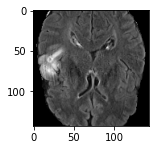

In [8]:
brats_datafiles.display_train_images()

## Define the loss and metrics

In [ ]:
def dice_coef(target, prediction, axis=(1, 2, 3), smooth=0.0001):
    """
    Sorenson Dice
    \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
    where T is ground truth mask and P is the prediction mask
    """
    prediction = tf.round(prediction)  # Round to 0 or 1

    intersection = tf.reduce_sum(target * prediction, axis=axis)
    union = tf.reduce_sum(target + prediction, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coef = numerator / denominator

    return tf.reduce_mean(coef)


def soft_dice_coef(target, prediction, axis=(1, 2, 3), smooth=0.0001):
    """
    Sorenson (Soft) Dice - Don't round predictions
    \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
    where T is ground truth mask and P is the prediction mask
    """
    intersection = tf.reduce_sum(target * prediction, axis=axis)
    union = tf.reduce_sum(target + prediction, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coef = numerator / denominator

    return tf.reduce_mean(coef)


def dice_loss(target, prediction, axis=(1, 2, 3), smooth=0.0001):
    """
    Sorenson (Soft) Dice loss
    Using -log(Dice) as the loss since it is better behaved.
    Also, the log allows avoidance of the division which
    can help prevent underflow when the numbers are very small.
    """
    intersection = tf.reduce_sum(prediction * target, axis=axis)
    p = tf.reduce_sum(prediction, axis=axis)
    t = tf.reduce_sum(target, axis=axis)
    numerator = tf.reduce_mean(intersection + smooth)
    denominator = tf.reduce_mean(t + p + smooth)
    dice_loss = -tf.math.log(2.*numerator) + tf.math.log(denominator)

    return dice_loss


## Define the 3D U-Net

Create a TensorFlow model.

In [ ]:
def unet_3d(input_dim=CROP_DIM, 
            filters=FILTERS, 
            number_output_classes = NUMBER_OUTPUT_CLASSES,
            use_upsampling=False, 
            concat_axis=-1,
            model_name = SAVED_MODEL_NAME):
    """
    3D U-Net
    """
    
    def ConvolutionBlock(x, name, filters, params):
        """
        Convolutional block of layers
        Per the original paper this is back to back 3D convs
        with batch norm and then ReLU.
        """

        x = K.layers.Conv3D(filters=filters, **params, name=name+"_conv_0")(x)
        x = K.layers.BatchNormalization(name=name+"_bn_0")(x)
        x = K.layers.Activation("relu", name=name+"_relu_0")(x)

        x = K.layers.Conv3D(filters=filters, **params, name=name+"_conv_1")(x)
        x = K.layers.BatchNormalization(name=name+"_bn_1")(x)
        x = K.layers.Activation("relu", name=name)(x)

        return x


    # Convolution parameters
    params = dict(kernel_size=(3, 3, 3), activation=None,
                  padding="same", 
                  kernel_initializer="he_uniform")

    # Transposed convolution parameters
    params_trans = dict(kernel_size=(2, 2, 2), strides=(2, 2, 2),
                        padding="same",
                        kernel_initializer="he_uniform")

    
    inputs = K.layers.Input(shape=input_dim, name="mrimages")

    # BEGIN - Encoding path
    encode_a = ConvolutionBlock(inputs, "encode_a", filters, params)
    pool_a = K.layers.MaxPooling3D(name="pool_a", pool_size=(2, 2, 2))(encode_a)

    encode_b = ConvolutionBlock(pool_a, "encode_b", filters*2, params)
    pool_b = K.layers.MaxPooling3D(name="pool_b", pool_size=(2, 2, 2))(encode_b)

    encode_c = ConvolutionBlock(pool_b, "encode_c", filters*4, params)
    pool_c = K.layers.MaxPooling3D(name="pool_c", pool_size=(2, 2, 2))(encode_c)

    encode_d = ConvolutionBlock(pool_c, "encode_d", filters*8, params)
    pool_d = K.layers.MaxPooling3D(name="pool_d", pool_size=(2, 2, 2))(encode_d)

    encode_e = ConvolutionBlock(pool_d, "encode_e", filters*16, params)
    # END - Encoding path

    
    # BEGIN - Decoding path
    if use_upsampling:
        up = K.layers.UpSampling3D(name="up_e", size=(2, 2, 2),
                                   interpolation="bilinear")(encode_e)
    else:
        up = K.layers.Conv3DTranspose(name="transconv_e", filters=filters*8,
                                      **params_trans)(encode_e)
    concat_d = K.layers.concatenate(
        [up, encode_d], axis=concat_axis, name="concat_d")

    decode_c = ConvolutionBlock(concat_d, "decode_c", filters*8, params)

    if use_upsampling:
        up = K.layers.UpSampling3D(name="up_c", size=(2, 2, 2),
                                   interpolation="bilinear")(decode_c)
    else:
        up = K.layers.Conv3DTranspose(name="transconv_c", filters=filters*4,
                                      **params_trans)(decode_c)
    concat_c = K.layers.concatenate(
        [up, encode_c], axis=concat_axis, name="concat_c")

    decode_b = ConvolutionBlock(concat_c, "decode_b", filters*4, params)

    if use_upsampling:
        up = K.layers.UpSampling3D(name="up_b", size=(2, 2, 2),
                                   interpolation="bilinear")(decode_b)
    else:
        up = K.layers.Conv3DTranspose(name="transconv_b", filters=filters*2,
                                      **params_trans)(decode_b)
    concat_b = K.layers.concatenate(
        [up, encode_b], axis=concat_axis, name="concat_b")

    decode_a = ConvolutionBlock(concat_b, "decode_a", filters*2, params)

    if use_upsampling:
        up = K.layers.UpSampling3D(name="up_a", size=(2, 2, 2),
                                   interpolation="bilinear")(decode_a)
    else:
        up = K.layers.Conv3DTranspose(name="transconv_a", filters=filters,
                                      **params_trans)(decode_a)
    concat_a = K.layers.concatenate(
        [up, encode_a], axis=concat_axis, name="concat_a")
    
    conv_out = ConvolutionBlock(concat_a, "conv_out", filters, params)

    # END - Decoding path    

    
    prediction = K.layers.Conv3D(name="prediction_mask",
                                 filters=number_output_classes, kernel_size=(1, 1, 1),
                                 activation="sigmoid")(conv_out)

    model = K.models.Model(inputs=[inputs], outputs=[prediction], name=model_name)

    model.summary()

    return model

In [ ]:
model = unet_3d(input_dim=CROP_DIM, 
            filters=FILTERS, 
            number_output_classes = NUMBER_OUTPUT_CLASSES,
            use_upsampling=False, 
            concat_axis=-1,
            model_name = SAVED_MODEL_NAME)

model.compile(optimizer="adam", loss=dice_loss, metrics=[dice_coef, soft_dice_coef])

## Define the training callbacks

This includes model checkpoints and TensorBoard logs.

In [ ]:
saved_model_w_epoch = SAVED_MODEL_NAME + '_epoch_{epoch:02d}'
saved_model_w_epoch

In [ ]:
model_path = Path(MODEL_DIR / saved_model_w_epoch)
checkpoint = K.callbacks.ModelCheckpoint(filepath=model_path,
                                         verbose=1,
                                         save_best_only=True)

# TensorBoard
logs_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_logs = K.callbacks.TensorBoard(log_dir=logs_dir)

callbacks = [checkpoint, tb_logs]


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs 

## Train the model

In [ ]:
steps_per_epoch = brats_datafiles.num_train // BATCH_SIZE_TRAIN

In [ ]:
model.fit(brats_datafiles.get_train(), 
          epochs=NUM_EPOCHS, 
          steps_per_epoch=steps_per_epoch,
          validation_data=brats_datafiles.get_validate(), 
          callbacks=callbacks)

## Evaluate the model

Evaluate the final model on the test dataset. This gives us an idea of how the model should perform on data it has never seen.

In [ ]:
test_loss, test_dice_coef, test_soft_dice_coef = model.evaluate(brats_datafiles.get_test())

print("Average Dice Coefficient on test dataset = {:.4f}".format(test_dice_coef))

In [ ]:
save_path = Path(MODEL_DIR / SAVED_MODEL_NAME / SAVED_MODEL_NAME).with_suffix(".h5")
model.save(save_path)

In [ ]:
print(f'Absolute path where the base tf model in fp32 precisions is saved:\n {save_path.resolve()}')